In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
import warnings

%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

## Question 1

Using PyMC3, change the parameters of the prior beta distribution in our_first_model to match those of the previous chapter. Compare the results to the previous chapter. Replace the beta distribution with a uniform one in the interval \[0,1\]. 

* Are the results equivalent to the Beta($\alpha$=1, $\beta$=1)? 
  - Yes, summary values for both models are very close, almost identical
* Is the sampling slower, faster, or the same?
  - Much faster, 3s vs 22s
* What about using a larger interval such as \[-1, 2\]?
  - Summary values are still close, but less close than previous uniform(0, 1) theta. Sampling time is identical.
* Does the model run? What errors do you get?
  - Second model shows more divergence warnings.

In [3]:
np.random.seed(123)

trials = 4
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real, size=trials)

with pm.Model() as our_first_model:
#     θ = pm.Beta('θ', alpha=1., beta=1.)
    theta = pm.Uniform("theta", lower=0, upper=1)
    y = pm.Bernoulli("y", p=theta, observed=data)
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:03<00:00, 1501.18draws/s]
The acceptance probability does not match the target. It is 0.8832139313883716, but should be close to 0.8. Try to increase the number of tuning steps.


In [4]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.335,0.179,0.039,0.663,0.004,0.003,1724.0,1724.0,1683.0,2107.0,1.0


In [5]:
with pm.Model() as our_first_model:
    theta = pm.Uniform("theta", lower=-1, upper=2)
    y = pm.Bernoulli("y", p=theta, observed=data)
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains, 465 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1207.20draws/s]
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.


In [6]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.331,0.178,0.025,0.645,0.005,0.004,1135.0,1087.0,1188.0,1385.0,1.0


## Question 2

Read about the [coal mining disaster model that is part of the PyMC3 documentation](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters). Try to implement and run this model by yourself.
- Model is defined in passage.
- Missing data imputation only available for Pandas series not Numpy arrays (see [discourse](https://discourse.pymc.io/t/missing-values-in-a-model/2157/5)).

In [7]:
disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                 3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                 2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
                 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                 0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                 3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)

with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(), testval=1900)
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)
    disasters = pm.Poisson('disasters', rate, observed=disaster_data)
    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:17<00:00, 2335.87draws/s]
The number of effective samples is smaller than 10% for some parameters.


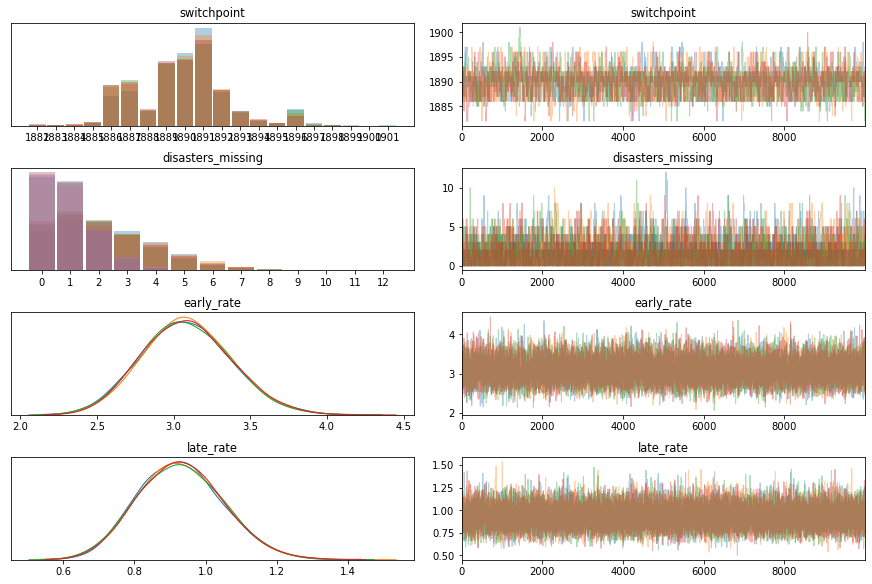

In [8]:
_ = pm.traceplot(trace)

## Question 3

Modify model_g, change the prior for the mean to a Gaussian distribution centered at the empirical mean, and play with a couple of reasonable values for the standard deviation of this prior. 
- How robust/sensitive are the inferences to these changes? 
  - Inferences seem sensitive to choice of standard deviation.
- What do you think of using a Gaussian, which is an unbounded distribution (goes from -∞ to ∞), to model bounded data such as this? Remember that we said it is not possible to get values below 0 or above 100.
  - Probably not a good choice.

In [9]:
with pm.Model() as model_g:
    mu = pm.Normal("mu", mu=55, sd=5)
    sig = pm.HalfNormal("sig", sd=10)
    y = pm.Normal("y", mu=mu, sd=sig, observed=data)
    trace_g1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1275.84draws/s]


In [10]:
pm.summary(trace_g1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,48.773,5.097,39.274,58.410,0.101,0.072,2561.0,2539.0,2564.0,2218.0,1.0
sig,29.365,5.076,20.970,39.797,0.097,0.069,2764.0,2743.0,2768.0,2678.0,1.0


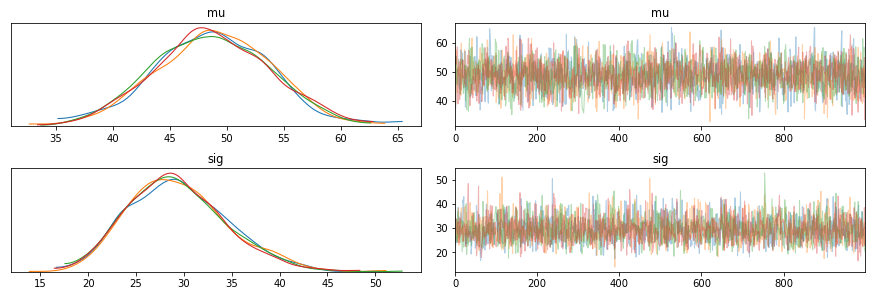

In [11]:
_ = az.plot_trace(trace_g1)

In [12]:
with pm.Model() as model_g:
    mu = pm.Normal("mu", mu=55, sd=7)
    sig = pm.HalfNormal("sig", sd=10)
    y = pm.Normal("y", mu=mu, sd=sig, observed=data)
    trace_g2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:05<00:00, 1156.99draws/s]
The acceptance probability does not match the target. It is 0.8950189442000035, but should be close to 0.8. Try to increase the number of tuning steps.


In [13]:
pm.summary(trace_g2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,42.642,7.518,29.008,57.353,0.189,0.134,1582.0,1582.0,1586.0,1600.0,1.0
sig,26.980,5.413,16.997,36.949,0.130,0.092,1747.0,1747.0,1702.0,1417.0,1.0


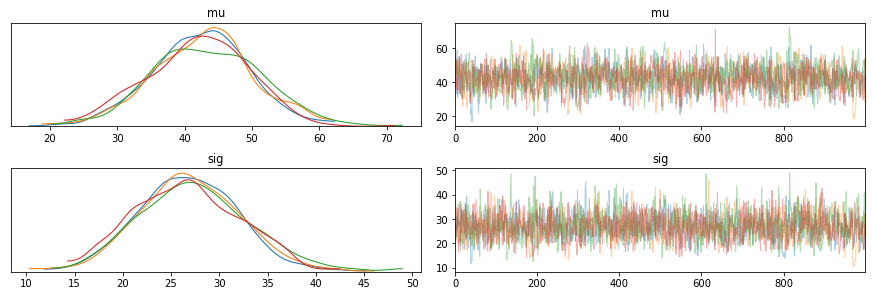

In [14]:
_ = az.plot_trace(trace_g2)

## Question 4

* Using the data in the chemical_shifts.csv file, compute the empirical mean and the standard deviation with and without outliers. 
  - removed outliers using both rules mentioned in text.
* Compare those results to the Bayesian estimation using the Gaussian and Student's t-distribution. 
  - results from model_g with Gaussian likelihood model has (mean, std) of (53.49 and 3.54) and with Student-T model the values are (53.0, 2.2). With dataset filtered using outlier rules 1 and 2, the values are (52.9, 2.3) and (52.9, 2.3). Fit looks good for the truncated dataset.
* Repeat the exercise by adding more outliers.

In [15]:
chemshifts_df = pd.read_csv("../BAP/code/data/chemical_shifts.csv", header=None)
data_full = [x for x in chemshifts_df[0].values]
mean_full, std_full = np.mean(data_full), np.std(data_full)

# outlier rule 1: drop everything more than 1.5 IQR
lower_quartile, upper_quartile = np.percentile(data_full, 25), np.percentile(data_full, 75)
iqr = upper_quartile - lower_quartile
data_f1 = [x for x in data_full if (x >= lower_quartile - 1.5 * iqr and 
                                    x <= upper_quartile + 1.5 * iqr)]
mean_f1, std_f1 = np.mean(data_f1), np.std(data_f1)

# outlier rule: drop everything more than 2 standard deviations from mean
data_f2 = [x for x in data_full if (x >= mean_full - 2 * std_full and 
                                    x <= mean_full + 2 * std_full)]
mean_f2, std_f2 = np.mean(data_f2), np.std(data_f2)

print("lengths:", len(data_full), len(data_f1), len(data_f2))
print("means  :", mean_full, mean_f1, mean_f2)
print("std    :", std_full, std_f1, std_f2)

lengths: 48 46 46
means  : 53.49645833333333 52.95260869565218 52.95260869565218
std    : 3.4200063898474258 2.1950303897892387 2.1950303897892387


In [16]:
with pm.Model() as model_f1:
    mu = pm.Uniform("mu", 40, 75)
    sig = pm.HalfNormal("sig", sd=10)
    y = pm.Normal("y", mu=mu, sd=sig, observed=data_f1)
    trace_f1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:05<00:00, 1168.57draws/s]


In [17]:
pm.summary(trace_f1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,52.949,0.339,52.297,53.572,0.006,0.004,3280.0,3280.0,3298.0,2705.0,1.0
sig,2.277,0.248,1.845,2.745,0.005,0.003,2983.0,2884.0,3112.0,2367.0,1.0


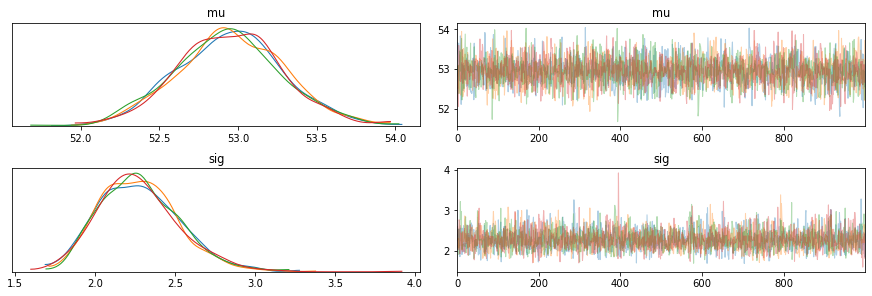

In [18]:
_ = az.plot_trace(trace_f1)

100%|██████████| 100/100 [00:00<00:00, 334.29it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


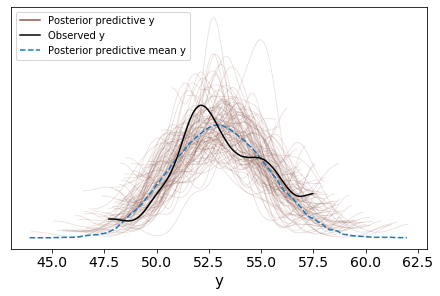

In [19]:
ypred_f1 = pm.sample_posterior_predictive(trace_f1, 100, model_f1)
data_f1_ppc = az.from_pymc3(trace=trace_f1, posterior_predictive=ypred_f1)
az.plot_ppc(data_f1_ppc)
_ = plt.legend(loc="best")

In [20]:
with pm.Model() as model_f2:
    mu = pm.Uniform("mu", 40, 75)
    sig = pm.HalfNormal("sig", sd=10)
    y = pm.Normal("y", mu=mu, sd=sig, observed=data_f2)
    trace_f2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:05<00:00, 1144.53draws/s]
The acceptance probability does not match the target. It is 0.87868221017348, but should be close to 0.8. Try to increase the number of tuning steps.


In [21]:
pm.summary(trace_f2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,52.948,0.326,52.289,53.496,0.006,0.004,3463.0,3463.0,3479.0,2095.0,1.0
sig,2.282,0.254,1.855,2.766,0.004,0.003,3545.0,3378.0,3590.0,2736.0,1.0


100%|██████████| 100/100 [00:00<00:00, 817.56it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


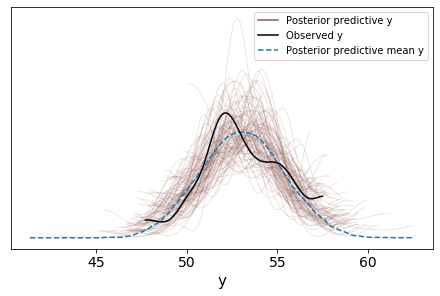

In [22]:
ypred_f2 = pm.sample_posterior_predictive(trace_f2, 100, model_f2)
data_f2_ppc = az.from_pymc3(trace=trace_f2, posterior_predictive=ypred_f2)
az.plot_ppc(data_f2_ppc)
_ = plt.legend(loc="best")

## Question 5

Modify the tips example to make it robust to outliers. Try with one shared for all groups and also with one per group. Run posterior predictive checks to assess these three models.
* Following models were constructed
  * Model 1: outliers removed using the 2 standard deviation rule + gaussian likelihood, shared model
  * Model 2: outliers removed using the 2 standard deviation rule + gaussian likelihood, per group model
  * Model 2: shared model using Student-T likelihood
  * Model 3: per group model using Student-T likelihood
* Overall, using standard deviation rule to remove outliers and using Gaussian likelihood did not result in very good posterior fit against the data. Shared model vs per-group model did not seem to make much difference, although the per-group model does indicate that the parameters for each group are different enough so they may not be adequately accounted for in a shared model. Replacing the Gaussian likelihood with a Student-T likelihood model on the entire data resulted in much better posterior fit. The per-group model resulted in a better posterior fit than the shared model.

In [23]:
tips_df = pd.read_csv("../BAP/code/data/tips.csv")
tips_df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [24]:
def find_if_outlier(x, mean, sd):
    return True if (x < mean - 2 * sd or x > mean + 2 * sd) else False

means, sds = {}, {}
for dow in tips_df["day"].unique():
    tip_amounts = tips_df[tips_df["day"] == dow]["tip"].values
    means[dow] = np.mean(tip_amounts)
    sds[dow] = np.std(tip_amounts)
    
tips_df["is_outlier"] = tips_df.apply(
    lambda row: find_if_outlier(row["tip"], means[row["day"]], sds[row["day"]]), axis=1)
rtips_df = tips_df[tips_df["is_outlier"] == False]

len(tips_df), len(rtips_df)

(244, 234)

In [25]:
data = rtips_df["tip"].values

with pm.Model() as model_1:
    mu = pm.Normal("mu", mu=0, sd=10)
    sig = pm.HalfNormal("sig", sd=10)
    y = pm.Normal("y", mu=mu, sd=sig, observed=data)
    trace_1 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:11<00:00, 1935.78draws/s]


In [26]:
pm.summary(trace_1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,2.829,0.073,2.692,2.965,0.001,0.0,18653.0,18649.0,18620.0,14340.0,1.0
sig,1.103,0.052,1.006,1.201,0.000,0.0,18075.0,17933.0,18183.0,13612.0,1.0


100%|██████████| 100/100 [00:00<00:00, 960.25it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


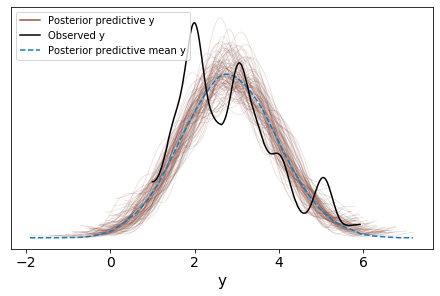

In [27]:
ypred_1 = pm.sample_posterior_predictive(trace_1, 100, model_1)
ppcdata_1 = az.from_pymc3(trace=trace_1, posterior_predictive=ypred_1)
az.plot_ppc(ppcdata_1)
_ = plt.legend(loc="best")

In [28]:
dow_idx = pd.Categorical(rtips_df['day'], categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
num_dow = len(np.unique(dow_idx))

with pm.Model() as model_2:
    mus = pm.Normal("mu", mu=0, sd=10, shape=num_dow)
    sigs = pm.HalfNormal("sig", sd=10, shape=num_dow)
    y = pm.Normal("y", mu=mus[dow_idx], sd=sigs[dow_idx], observed=data)
    trace_2 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:14<00:00, 1489.62draws/s]


In [29]:
pm.summary(trace_2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],2.654,0.139,2.393,2.918,0.001,0.001,22394.0,22339.0,22434.0,14462.0,1.0
mu[1],2.622,0.239,2.173,3.077,0.002,0.001,20183.0,20026.0,20503.0,13971.0,1.0
mu[2],2.690,0.117,2.474,2.913,0.001,0.001,25920.0,25878.0,25925.0,15619.0,1.0
mu[3],3.172,0.137,2.917,3.430,0.001,0.001,25284.0,25284.0,25320.0,14980.0,1.0
sig[0],1.097,0.103,0.907,1.291,0.001,0.000,22524.0,21601.0,23658.0,14519.0,1.0
sig[1],0.999,0.188,0.679,1.343,0.001,0.001,18787.0,17022.0,21259.0,14092.0,1.0
sig[2],1.062,0.084,0.913,1.225,0.001,0.000,23009.0,22104.0,23888.0,14669.0,1.0
sig[3],1.166,0.098,0.991,1.353,0.001,0.000,22940.0,22249.0,23693.0,14562.0,1.0


100%|██████████| 100/100 [00:00<00:00, 709.22it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


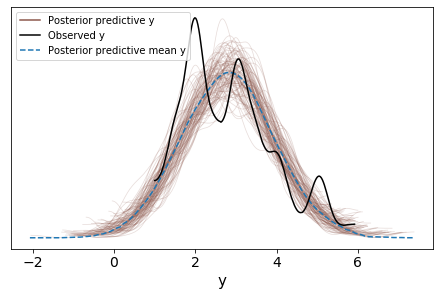

In [30]:
ypred_2 = pm.sample_posterior_predictive(trace_2, 100, model_2)
ppcdata_2 = az.from_pymc3(trace=trace_2, posterior_predictive=ypred_2)
az.plot_ppc(ppcdata_2)
_ = plt.legend(loc="best")

In [31]:
data = tips_df["tip"].values

with pm.Model() as model_3:
    mu = pm.Normal("mu", mu=0, sd=10)
    sig = pm.HalfNormal("sig", sd=10)
    nu = pm.Exponential("nu", 1/30)
    y = pm.StudentT("y", mu=mu, sd=sig, nu=nu, observed=data)
    trace_3 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sig, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:14<00:00, 1530.12draws/s]


In [32]:
pm.summary(trace_3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,2.829,0.088,2.664,2.994,0.001,0.001,10745.0,10745.0,10742.0,13005.0,1.0
sig,1.095,0.084,0.943,1.257,0.001,0.001,8174.0,8159.0,8191.0,11500.0,1.0
nu,6.304,3.075,2.771,10.672,0.044,0.039,4939.0,3133.0,7913.0,9204.0,1.0


100%|██████████| 100/100 [00:00<00:00, 1180.06it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


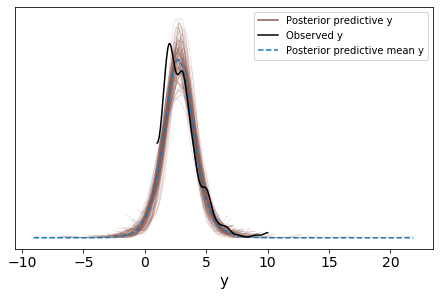

In [33]:
ypred_3 = pm.sample_posterior_predictive(trace_3, 100, model_3)
ppcdata_3 = az.from_pymc3(trace=trace_3, posterior_predictive=ypred_3)
az.plot_ppc(ppcdata_3)
_ = plt.legend(loc="best")

In [34]:
dow_idx = pd.Categorical(tips_df['day'], categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
num_dow = len(np.unique(dow_idx))

with pm.Model() as model_4:
    mus = pm.Normal("mus", mu=0, sd=10, shape=num_dow)
    sigs = pm.HalfNormal("sigs", sd=10, shape=num_dow)
    nus = pm.Exponential("nus", 1/30, shape=num_dow)
    y = pm.StudentT("y", mu=mus[dow_idx], sd=sigs[dow_idx], nu=nus[dow_idx], observed=data)
    trace_4 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nus, sigs, mus]
Sampling 4 chains, 11 divergences: 100%|██████████| 22000/22000 [00:20<00:00, 1085.58draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [35]:
pm.summary(trace_4)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mus[0],2.677,0.177,2.346,3.011,0.001,0.001,20167.0,20167.0,20362.0,12193.0,1.0
mus[1],2.726,0.260,2.240,3.226,0.002,0.001,29685.0,29301.0,29975.0,14369.0,1.0
mus[2],2.663,0.131,2.408,2.901,0.001,0.001,28871.0,28368.0,29217.0,14881.0,1.0
mus[3],3.234,0.143,2.970,3.507,0.001,0.001,31297.0,31297.0,31316.0,14306.0,1.0
sigs[0],1.156,0.151,0.858,1.437,0.001,0.001,12987.0,12987.0,13744.0,8392.0,1.0
sigs[1],1.063,0.206,0.715,1.458,0.001,0.001,24391.0,21592.0,26828.0,14304.0,1.0
sigs[2],0.974,0.136,0.727,1.232,0.001,0.001,18523.0,17754.0,19165.0,14993.0,1.0
sigs[3],1.218,0.112,1.020,1.436,0.001,0.000,27460.0,26983.0,27400.0,13832.0,1.0
nus[0],27.886,27.720,1.515,78.577,0.195,0.141,20211.0,19248.0,14059.0,8810.0,1.0
nus[1],36.473,31.045,1.049,93.175,0.189,0.157,27039.0,19520.0,27113.0,13913.0,1.0


100%|██████████| 100/100 [00:00<00:00, 771.57it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


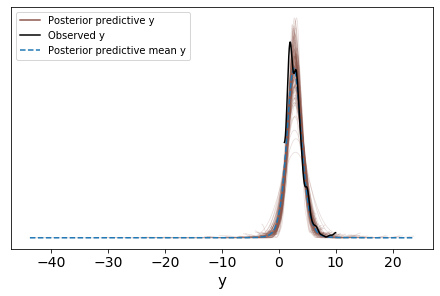

In [36]:
ypred_4 = pm.sample_posterior_predictive(trace_4, 100, model_4)
ppcdata_4 = az.from_pymc3(trace=trace_4, posterior_predictive=ypred_4)
az.plot_ppc(ppcdata_4)
_ = plt.legend(loc="best")

## Question 6

Compute the probability of superiority directly from the posterior (without computing Cohen's d first). You can use the `pm.sample_posterior_predictive()` function to take a sample from each group. Is it really different from the calculation assuming normality? Can you explain the result?

* Output of `sample_posterior_predictive()` is a matrix of 100 simulations of the posterior `y`, each simulation containing `len(tips_df)` values. So we can use the `dow_idx` to separate the traces out.
* Probability of superiority definition: probability that a data point taken at random from one group has a larger value than one taken at random from another group. We will look at each group pair and conduct 100 random lookups, and choose the winner based on the results.

In [37]:
ypred_4["y"].shape

(100, 244)

In [38]:
data_by_group = {}
for sim_id in range(ypred_4["y"].shape[0]):
    dataset = ypred_4["y"][sim_id]
    for row_id in range(ypred_4["y"].shape[1]):
        group_id = dow_idx[row_id]
        if group_id in data_by_group.keys():
            data_by_group[group_id].append(ypred_4["y"][sim_id][row_id])
        else:
            data_by_group[group_id] = [ypred_4["y"][sim_id][row_id]]
            
print("#-groups:", len(data_by_group))
print("#-recs/group:", len(data_by_group[0]), len(data_by_group[1]), len(data_by_group[2]), len(data_by_group[3]))

#-groups: 4
#-recs/group: 6200 1900 8700 7600


In [39]:
def prob_of_superiority(dataset_1, dataset_2, num_trials=100):
    trials_1 = np.random.choice(dataset_1, size=num_trials)
    trials_2 = np.random.choice(dataset_2, size=num_trials)
    return np.count_nonzero(trials_1 > trials_2) / num_trials

id2name = { 0:"Thu", 1:"Fri", 2:"Sat", 3:"Sun" }
for id_pair in [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]:
    pos = prob_of_superiority(data_by_group[id_pair[0]], data_by_group[id_pair[1]])
    rpos = 1 - pos
    print("{:s}-{:s}, POS: {:.3f}".format(id2name[id_pair[0]], id2name[id_pair[1]], pos))
    print("{:s}-{:s}, POS: {:.3f}".format(id2name[id_pair[1]], id2name[id_pair[0]], rpos))

Thu-Fri, POS: 0.410
Fri-Thu, POS: 0.590
Thu-Sat, POS: 0.510
Sat-Thu, POS: 0.490
Thu-Sun, POS: 0.490
Sun-Thu, POS: 0.510
Fri-Sat, POS: 0.500
Sat-Fri, POS: 0.500
Fri-Sun, POS: 0.370
Sun-Fri, POS: 0.630
Sat-Sun, POS: 0.400
Sun-Sat, POS: 0.600


## Question 7

Repeat the exercise we did with model_h. This time, without hierarchical structure, use a flat prior such as Beta($\alpha$=1, $\beta$=1). Compare the results of both models.

* Data represents water samples collected from 3 different parts of the city and marked with 1 if concentration of lead is above threshold and 0 if not.
* Book describes hierarchical model with each set of samples having its own Bernoulli distribution driven by its own Beta distribution, which is further driven by its own HalfNormal and Beta distributions for its alpha and beta parameters.
* Results of using a flat model are very similar to the results of the hierarchical model, most likely because the distribution of the 3 samples are nearly identical, so hierarchical model does not provide lot of benefit.

In [40]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []

for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))
    
len(data)

90

In [41]:
with pm.Model() as model_nh:
    theta = pm.Beta("theta", alpha=1, beta=1)
    y = pm.Bernoulli("y", p=theta, observed=data)
    trace_nh = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:06<00:00, 1642.32draws/s]
The acceptance probability does not match the target. It is 0.8805317867560336, but should be close to 0.8. Try to increase the number of tuning steps.


In [42]:
pm.summary(trace_nh)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.597,0.051,0.502,0.693,0.001,0.001,3060.0,3060.0,3071.0,5600.0,1.0


## Question 8

Create a hierarchical version of the tips example by partially pooling across the days of the week. Compare the results to those obtained without the hierarchical structure.

* Good fit of posterior to data. Shape of fit comparable to flat shared model. The per-group model shows a tighter fit to the data.

In [43]:
data = tips_df["tip"].values

dow_idx = pd.Categorical(tips_df['day'], categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
num_dow = len(np.unique(dow_idx))

with pm.Model() as model_th:
    
    hyper_mu = pm.Normal("hyper_mu", mu=0, sd=10)
    hyper_sd = pm.HalfNormal("hyper_sig", sd=10)
    hyper_nu = pm.Exponential("hyper_nu", 1/30)
    
    mus = pm.Normal("mus", mu=hyper_mu, sd=hyper_sd, shape=num_dow)
    sigs = pm.HalfNormal("sigs", sd=hyper_sd, shape=num_dow)
    nus = pm.Exponential("nus", hyper_nu, shape=num_dow)
    
    y = pm.StudentT("y", mu=mus[dow_idx], sd=sigs[dow_idx], nu=nus[dow_idx], observed=data)
    trace_th = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nus, sigs, mus, hyper_nu, hyper_sig, hyper_mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:39<00:00, 559.38draws/s]


In [44]:
pm.summary(trace_th)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
hyper_mu,2.785,0.555,1.793,3.863,0.005,0.004,11155.0,11155.0,13148.0,9836.0,1.0
mus[0],2.606,0.181,2.261,2.942,0.002,0.001,12310.0,12310.0,12275.0,14541.0,1.0
mus[1],2.729,0.245,2.263,3.188,0.002,0.001,16522.0,16055.0,16835.0,12479.0,1.0
mus[2],2.660,0.129,2.415,2.900,0.001,0.001,18232.0,18076.0,18297.0,12845.0,1.0
mus[3],3.204,0.143,2.931,3.471,0.001,0.001,18185.0,18125.0,18225.0,15006.0,1.0
hyper_sig,1.013,0.368,0.513,1.687,0.004,0.003,10630.0,9742.0,13605.0,11634.0,1.0
hyper_nu,0.143,0.111,0.003,0.342,0.001,0.001,10953.0,10953.0,8408.0,7532.0,1.0
sigs[0],1.051,0.164,0.742,1.362,0.002,0.001,9861.0,9861.0,10008.0,10344.0,1.0
sigs[1],0.972,0.191,0.632,1.332,0.001,0.001,16133.0,15637.0,16227.0,13678.0,1.0
sigs[2],0.943,0.128,0.705,1.184,0.001,0.001,13832.0,13445.0,14160.0,13838.0,1.0


100%|██████████| 100/100 [00:00<00:00, 753.47it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


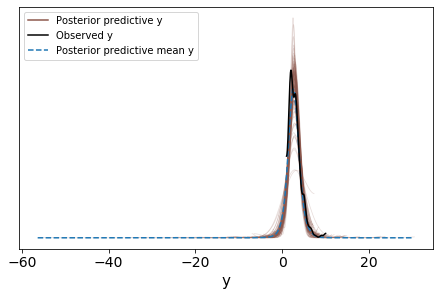

In [45]:
ypred_th = pm.sample_posterior_predictive(trace_th, 100, model_th)
ppc_th = az.from_pymc3(trace=trace_th, posterior_predictive=ypred_th)
az.plot_ppc(ppc_th)
_ = plt.legend(loc="best")

## Question 9

PyMC3 can create directed acyclic graphs (DAGs) from models that are very similar to Kruschke's diagrams. You can obtain them using the `pm.model_to_graphviz()` function. Generate a DAG for each model in this chapter.

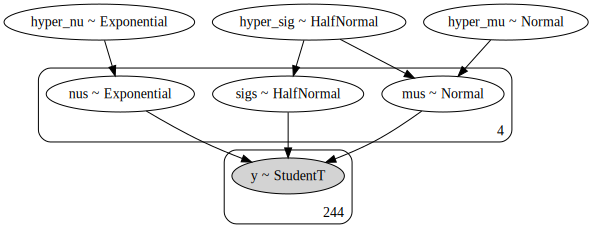

In [46]:
pm.model_to_graphviz(model_th)